In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from torchvision import datasets, models

import easydict
#import argparse
import matplotlib.pyplot as plt

In [2]:
class CustomCi(Dataset):
    def __init__(self, cifar_dataset):
        self.cifar_dataset = cifar_dataset

    def __len__(self):
        return len(self.cifar_dataset)

    def __getitem__(self, idx):
        image, label = self.cifar_dataset[idx]
        return image, label

In [3]:
parser = argparse.ArgumentParser()

parser.add_argument('--epochs', type=int, default=10)
parser.add_argument('--batch_size', type=int, default=64)
parser.add_argument('--lr', type=float, default=0.001)

args = parser.parse_args()

NameError: name 'argparse' is not defined

In [3]:
args = easydict.EasyDict({
    "batch_size":64,
    "epochs":10,
    "lr":0.001
})

In [4]:
#def CIFAR10_DATA(batch_size=64):
def CIFAR10_DATA(batch_size=args.batch_size):
    cifar_train = datasets.CIFAR10(root='./', download = True, train=True, transform=transforms.ToTensor())
    cifar_test = datasets.CIFAR10(root='./', download = True, train=False, transform=transforms.ToTensor())

    train_data, valid_data = random_split(cifar_train, [40000, 10000])

    #train_dataset = CustomCi(cifar_train)
    train_dataset = CustomCi(train_data)
    valid_dataset = CustomCi(valid_data)
    test_dataset = CustomCi(cifar_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, valid_loader, test_loader

In [5]:
train_loader, valid_loader, test_loader = CIFAR10_DATA()

100%|██████████| 170498071/170498071 [00:13<00:00, 12617282.16it/s]


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


In [6]:
model = models.vgg16_bn(pretrained=True)

#torch.save(model.state_dict(), 'vgg16_weights.pth')
#model.fc = torch.nn.Linear(model.fc.in_features, 10)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:03<00:00, 150MB/s]


In [7]:
class pretrained_vgg(nn.Module):
  def __init__(self, model):
    super(pretrained_vgg, self).__init__()
    self.features = nn.Sequential(
        *list(model.features.children())
    )

    self.linear = nn.Sequential(
        nn.Linear(512, 512),
        nn.ReLU(),
        nn.Linear(512, 128),
        nn.ReLU(),
        nn.Linear(128, 10)
    )

  def forward(self, x):
    out = self.features(x).squeeze()
    out = self.linear(out)
    return out

In [8]:
vgg16 = pretrained_vgg(model)

#state_dict = torch.load('vgg16_weights.pth')
#vgg16.load_state_dict(state_dict)
#vgg16.load_state_dict(torch.load('vgg16_weights.pth'))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.parameters(), lr=args.lr)

In [9]:
def train_model(vgg16, train_loader, optimizer, criterion, device):
    vgg16.train()
    train_loss = 0.0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = vgg16(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * data.size(0)

    return train_loss / len(train_loader.dataset)

def validate_model(vgg16, valid_loader, criterion, device):
    vgg16.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for data, target in valid_loader:
            data, target = data.to(device), target.to(device)
            output = vgg16(data)
            loss = criterion(output, target)

            valid_loss += loss.item() * data.size(0)

    return valid_loss / len(valid_loader.dataset)

def train_val(vgg16, epochs, train_loader, valid_loader, optimizer, criterion, device):
    train_losses = []
    valid_losses = []

    for epoch in range(args.epochs):
        train_loss = train_model(vgg16, train_loader, optimizer, criterion, device)
        valid_loss = validate_model(vgg16, valid_loader, criterion, device)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        print(f'Epoch: {epoch + 1}, Training Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}')

    return train_losses, valid_losses


In [10]:
train_losses, valid_losses = train_val(vgg16, args.epochs, train_loader,
                                       valid_loader, optimizer, criterion, device)

Epoch: 1, Training Loss: 0.9006, Validation Loss: 0.7550
Epoch: 2, Training Loss: 0.5457, Validation Loss: 0.6418
Epoch: 3, Training Loss: 0.4069, Validation Loss: 0.5501
Epoch: 4, Training Loss: 0.3181, Validation Loss: 0.4610
Epoch: 5, Training Loss: 0.2447, Validation Loss: 0.5031
Epoch: 6, Training Loss: 0.1958, Validation Loss: 0.6055
Epoch: 7, Training Loss: 0.1514, Validation Loss: 0.4745
Epoch: 8, Training Loss: 0.1325, Validation Loss: 0.5081
Epoch: 9, Training Loss: 0.1166, Validation Loss: 0.5438
Epoch: 10, Training Loss: 0.0966, Validation Loss: 0.4882


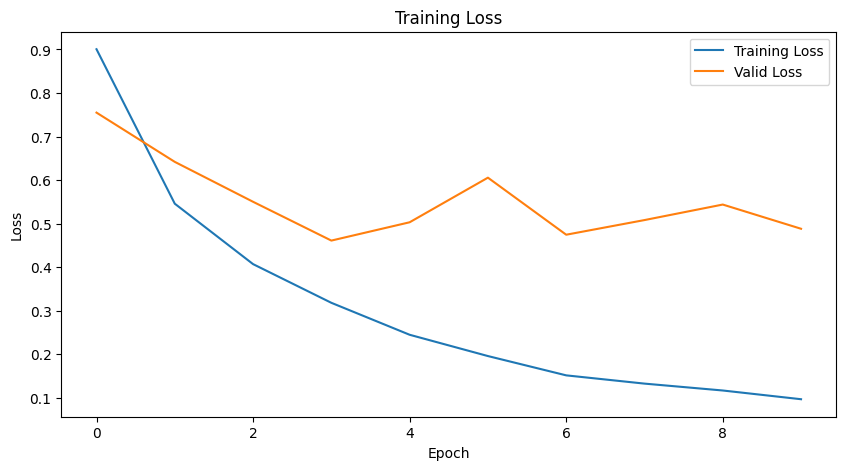

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

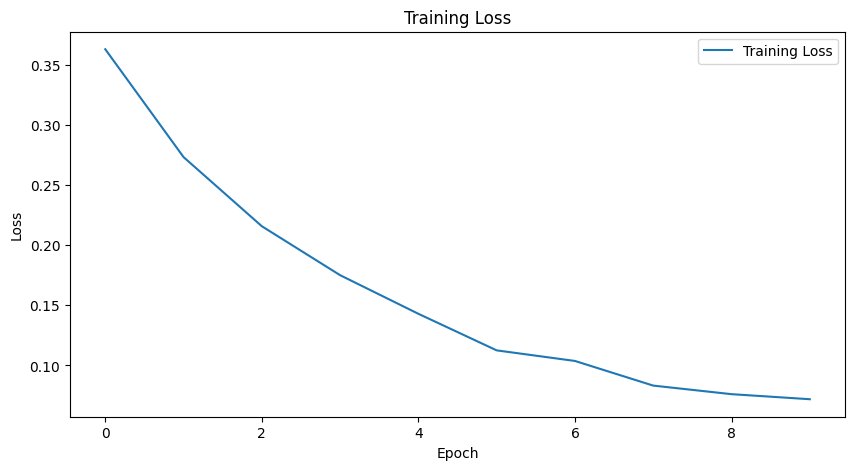

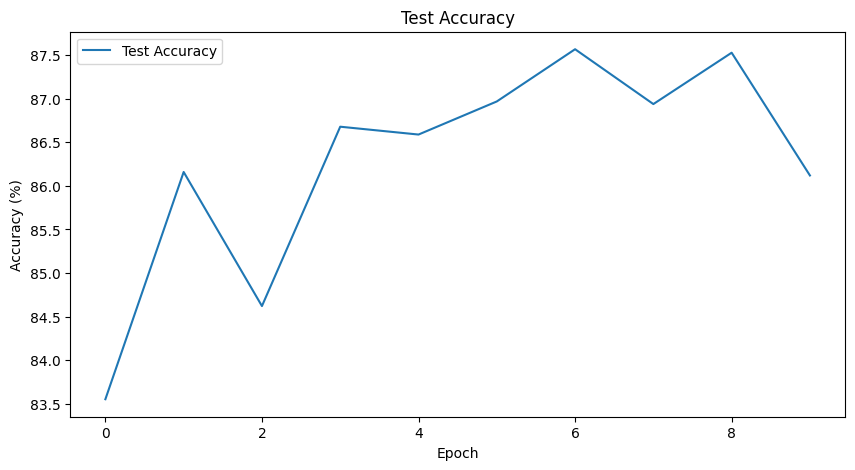

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()